In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw

import networkx as nx

from utils.graph_utils import *
from dataset.preprocess import *
from predict_logp.predict_logp import *
import torch_geometric as pyg

In [2]:
def read_data(dataset_path):
    all_logp = []
    all_smiles = []
    with open(dataset_path, newline='') as csvfile:
        reader = csv.reader(csvfile)

        for i, (logp, smiles) in enumerate(reader):
            # Some fields are empty, if logp is empty it will be caught by the exception. If smile is empty, conditional kicks in.
            try:
                if smiles is not None:
                    all_logp.append(float(logp))
                    all_smiles.append(smiles)
                else:
                    continue
            except:
                print("Row " + str(i) + "was not read.")
                continue
    return all_logp, all_smiles

In [86]:
scores, smiles = read_data("/Users/ADChen/Downloads/MD/2col/NSP15_6W01_A_1_F.Orderable_zinc_db_enaHLL.2col.csv")

Row 5834418was not read.
Row 5834419was not read.


In [87]:
train_data, valid_data, test_data = create_datasets(scores, smiles)
test_labels = np.array(test_data.logp)

In [88]:
# For weighted sampling 
def dock_score_weights(scores):                        
    weights = np.zeros(len(scores))                                          
    for idx, score in enumerate(scores):
        if score < -6:
            weight = 1
        else:
            weight = 0.1
        weights[idx] = weight                               
    return weights      

In [89]:
len(test_labels)

1166893

In [90]:
from scipy.stats import pearsonr
def tail_corr(a, b):
    assert len(a) == len(b)
    tail_corr = np.array([pearsonr(a[:i], b[:i])[0] for i in np.arange(30, len(a))], dtype=float)
    tail_corr = np.insert(tail_corr, 0, np.repeat(np.nan, 30))
    return tail_corr

In [91]:
_ = np.arange(1e6)

In [92]:
_noise = _ + np.random.randn(int(1e6))

In [93]:
tail_corr(_, _noise)

KeyboardInterrupt: 

# Custom Loss functions

In [ ]:
class exp_weighted_mse_loss():

In [168]:
def exp_weighted_mse(output, target):
    loss = torch.mean(torch.exp(-0.4*(target+5))*(output - target)**2)
    return loss

model = torch.nn.Linear(2, 2)
x = torch.randn(1, 2)
target = torch.randn(1, 2)
output = model(x)
loss = exp_weighted_mse(output, target)
loss.backward()
print(model.weight.grad)

tensor([[-0.3276, -1.2283],
        [ 0.0085,  0.0320]])


In [174]:
criterion(output,target)

tensor(0.6595, grad_fn=<MeanBackward0>)

In [173]:
criterion = exp_weighted_mse

In [169]:
output

tensor([[ 0.1011, -0.2856]], grad_fn=<AddmmBackward>)

In [170]:
model.weight

Parameter containing:
tensor([[-0.1056, -0.2275],
        [ 0.6924, -0.0929]], requires_grad=True)

In [171]:
model.bias

Parameter containing:
tensor([-0.3982, -0.1065], requires_grad=True)

# Histograms

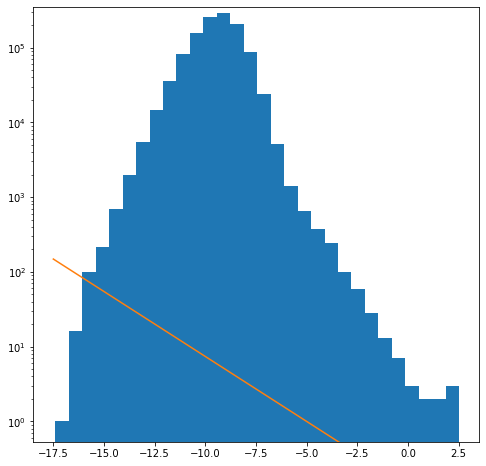

In [163]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111)

ax.hist(test_labels, bins = 30, log = True);
ax.set_ylim(0,350000)
ax.plot(np.linspace(-17.5,2.5,100), np.exp(-0.4*(np.linspace(-17.5,2.5,100)+5)))

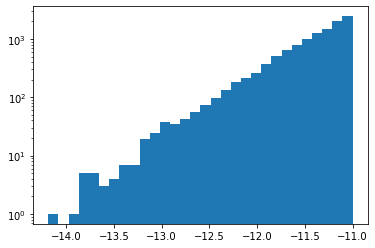

In [10]:
plt.hist(test_labels[test_labels<-11], bins = 30, log=True);

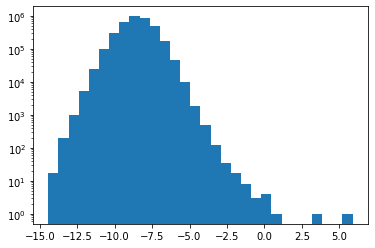

In [15]:
train_labels = np.array(train_data.logp)
plt.hist(train_labels, bins = 30, log=True);

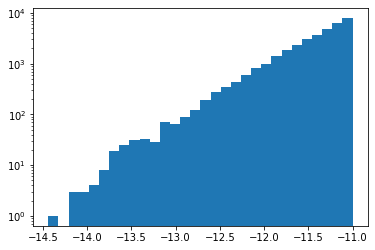

In [16]:
plt.hist(train_labels[train_labels < -11], bins = 30, log=True);